In [ ]:
# Conectar con drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil
from pathlib import Path

base_dir = '/content/drive/MyDrive/IA2/Proyecto/Dataset'
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Val')


In [ ]:
# Copiar 299 imágenes de cada clase a la nueva carpeta
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    balanced_class_path = os.path.join(balanced_dir, class_dir)
    Path(balanced_class_path).mkdir(parents=True, exist_ok=True)

    # Tomar las primeras 299 imágenes de cada clase
    for i, img_file in enumerate(os.listdir(class_path)):
        if i < 299:  # Limitar a 299 imágenes
            src = os.path.join(class_path, img_file)
            dst = os.path.join(balanced_class_path, img_file)
            shutil.copy(src, dst)
        else:
            break


NameError: name 'train_datagen' is not defined

In [ ]:
import tensorflow as tf

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,
    shuffle=True
)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,
    shuffle=False
)

# Get the class names before mapping transformations
class_names = train_dataset.class_names
print("Classes:", class_names)

# Normalize the pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Check the first batch of images and labels
for images, labels in train_dataset.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")

Found 14539 files belonging to 10 classes.
Found 3631 files belonging to 10 classes.
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Batch of images shape: (32, 256, 256, 3)
Batch of labels: [2 7 7 2 4 5 5 2 2 7 9 7 2 7 4 0 7 2 4 3 3 1 7 7 9 2 7 5 6 2 6 9]


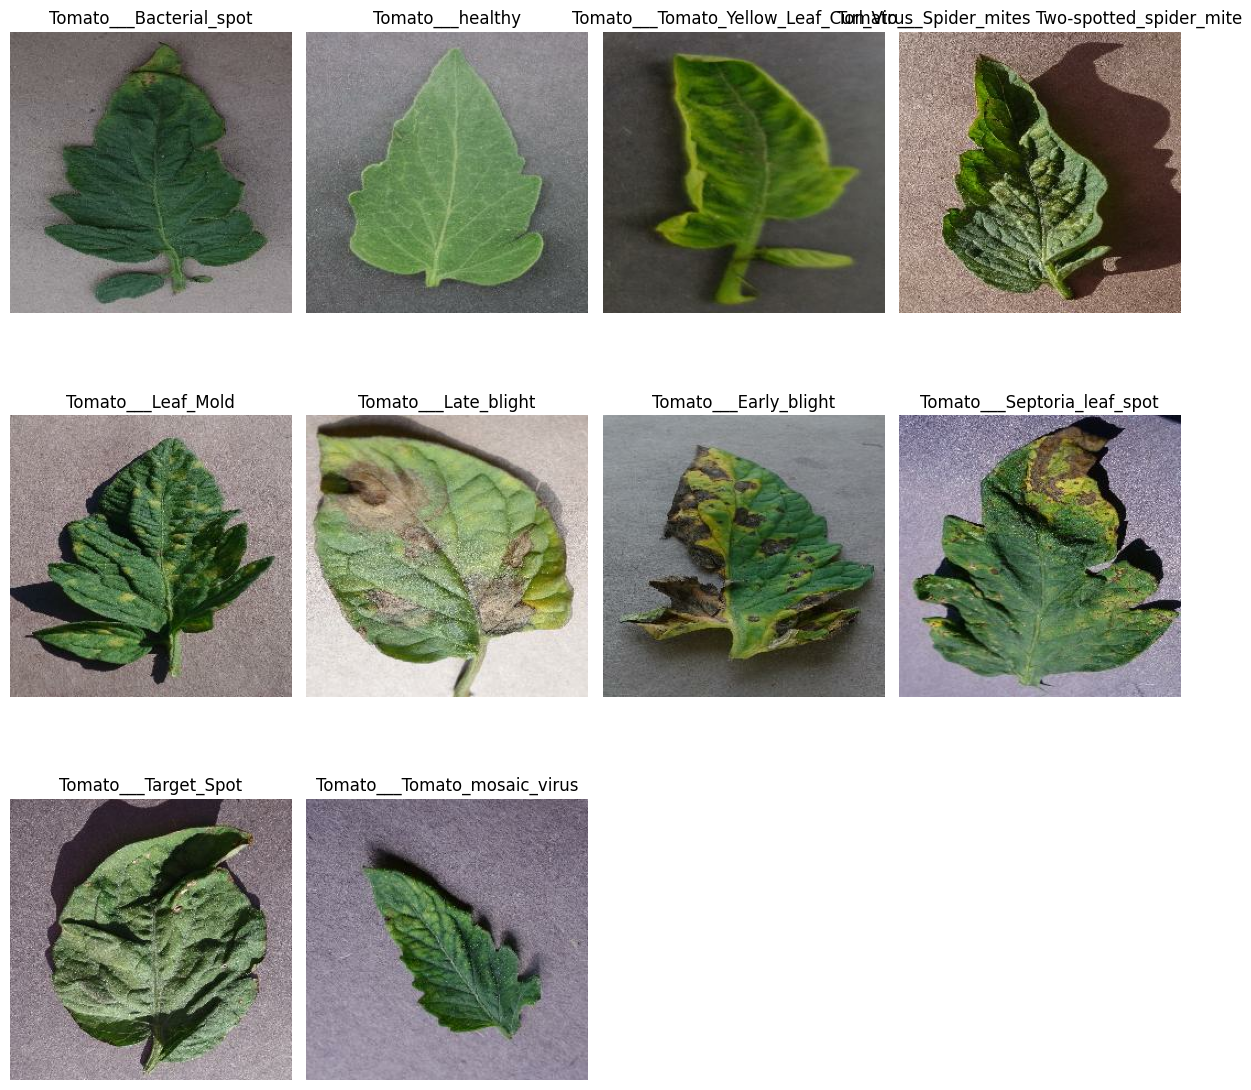

In [ ]:
import matplotlib.pyplot as plt

# Unbatch the dataset to access individual images and labels
unbatched_dataset = train_dataset.unbatch()

# Create a dictionary to track one image per class
displayed_classes = set()

# Plot images
plt.figure(figsize=(12, 12))
for image, label in unbatched_dataset:
    label = label.numpy()  # Convert label to numpy
    if label not in displayed_classes:  # Check if this class has already been displayed
        plt.subplot(3, 4, len(displayed_classes) + 1)  # Adjust grid size (rows, cols)
        # Reverse normalization to display the image properly
        plt.imshow(image.numpy())  # Already scaled to [0, 1] by normalization layer
        plt.title(class_names[label])  # Use class name as title
        plt.axis("off")
        displayed_classes.add(label)
    if len(displayed_classes) == len(class_names):  # Stop if all classes are displayed
        break

plt.tight_layout()
plt.show()

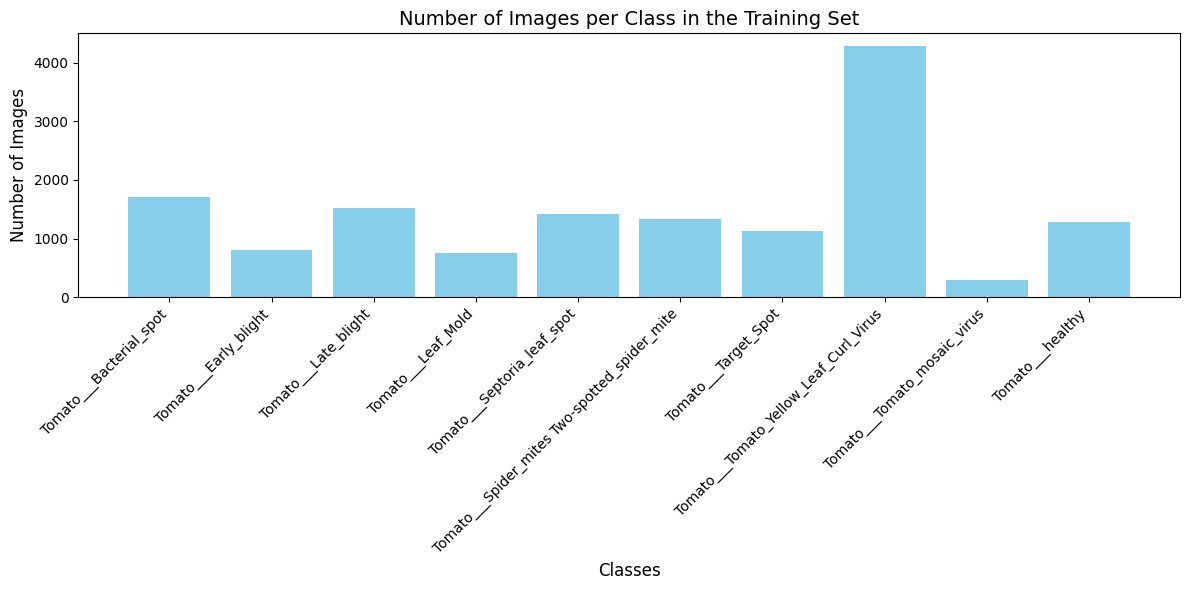

In [ ]:
import os
import matplotlib.pyplot as plt

# Get class names from subdirectories
class_names = sorted(os.listdir(train_dir))

# Count images per class using the file system
class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images per Class in the Training Set', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


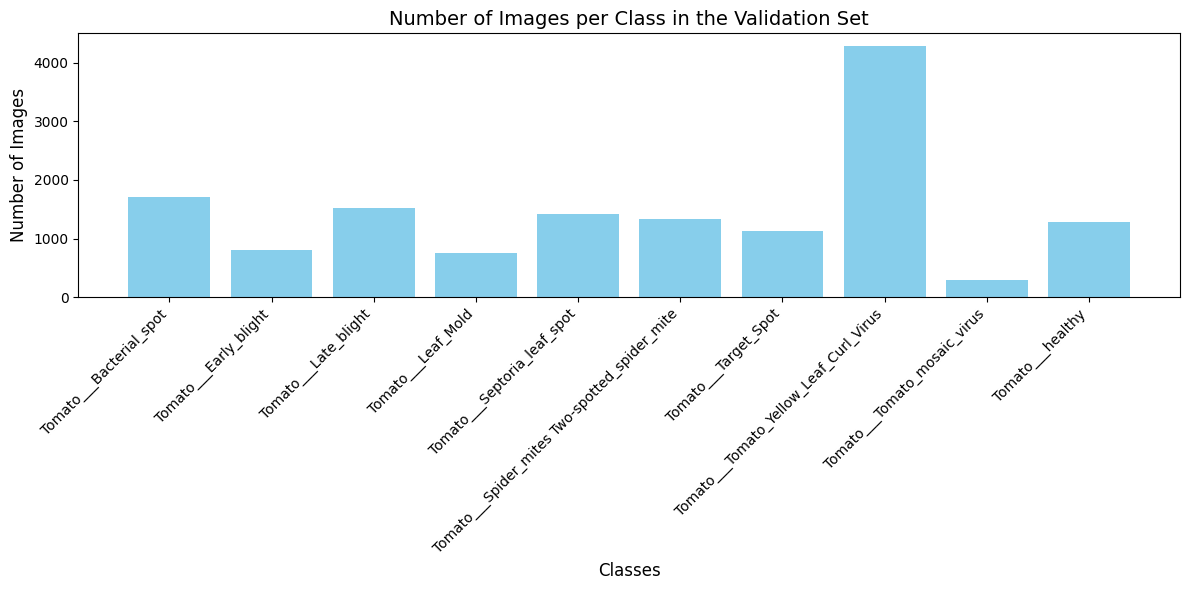

In [ ]:
import os
import matplotlib.pyplot as plt

# Get class names from subdirectories
class_names = sorted(os.listdir(train_dir))

# Count images per class using the file system
class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images per Class in the Validation Set', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Inicializar el modelo
model = Sequential()

# Aplanar la imagen 256x256x3 a un vector de 1D
model.add(Flatten(input_shape=(256, 256, 3)))

# Primera capa oculta
model.add(Dense(256, activation='relu'))

# Segunda capa oculta
model.add(Dense(128, activation='relu'))

# Tercera capa oculta
model.add(Dense(64, activation='relu'))

# Capa de salida con una neurona por clase y softmax para clasificación
model.add(Dense(10, activation='softmax'))  # 10 clases en total

# Compilación del modelo con las métricas especificadas
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10  # Puedes ajustar el número de épocas según el rendimiento y disponibilidad de recursos
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.2648 - auc: 0.6779 - loss: 3.5017 - precision: 0.2902 - recall: 0.2129 - val_accuracy: 0.2688 - val_auc: 0.6957 - val_loss: 2.8097 - val_precision: 0.3042 - val_recall: 0.1831
Epoch 2/10
 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4688 - auc: 0.8162 - loss: 1.8787 - precision: 0.5294 - recall: 0.2812

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.4688 - auc: 0.8162 - loss: 1.8787 - precision: 0.5294 - recall: 0.2812 - val_accuracy: 0.2000 - val_auc: 0.6785 - val_loss: 3.2058 - val_precision: 0.2222 - val_recall: 0.1333
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 315ms/step - accuracy: 0.3614 - auc: 0.7829 - loss: 2.2581 - precision: 0.4398 - recall: 0.2659 - val_accuracy: 0.1416 - val_auc: 0.6330 - val_loss: 3.9219 - val_precision: 0.1560 - val_recall: 0.1236
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.1562 - auc: 0.7410 - loss: 2.9542 - precision: 0.1667 - recall: 0.1250 - val_accuracy: 0.2667 - val_auc: 0.7852 - val_loss: 2.1662 - val_precision: 0.3636 - val_recall: 0.2667
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.4025 - auc: 0.7960 - loss: 2.1721 - precision: 0.4620 - recall: 0.2947 - val_accuracy: 0.4585 - val_auc: 0.8171 - val_loss: 2.0628 - val_precision: 0.5352 - val_recall: 0.3869
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 4

In [ ]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(val_generator)

# Imprimir las métricas de evaluación
print(f'Loss en Validación: {val_loss}')
print(f'Accuracy en Validación: {val_accuracy}')
print(f'AUC en Validación: {val_auc}')
print(f'Precision en Validación: {val_precision}')
print(f'Recall en Validación: {val_recall}')

114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.4670 - auc: 0.8596 - loss: 1.7311 - precision: 0.5546 - recall: 0.4082
Loss en Validación: 1.7478872537612915
Accuracy en Validación: 0.4646103084087372
AUC en Validación: 0.8579636216163635
Precision en Validación: 0.546234130859375
Recall en Validación: 0.40347012877464294


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Crear generadores de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = '/content/drive/MyDrive/IA2/Proyecto/Dataset/Balanced_Training'
val_dir = '/content/drive/MyDrive/IA2/Proyecto/Dataset/Val'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Inicializar el modelo
model = Sequential()

# Aplanar la imagen 256x256x3 a un vector de 1D
model.add(Flatten(input_shape=(256, 256, 3)))

# Primera capa oculta con Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Segunda capa oculta con Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Tercera capa oculta con Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Capa de salida con una neurona por clase y softmax para clasificación
model.add(Dense(10, activation='softmax'))  # 10 clases en total

# Compilación del modelo con el learning rate reducido y métricas adicionales
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])



Found 2990 images belonging to 10 classes.
Found 3631 images belonging to 10 classes.


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 361ms/step - accuracy: 0.0977 - auc: 0.5041 - loss: 28.8664 - precision: 0.1105 - recall: 0.0593 - val_accuracy: 0.0879 - val_auc: 0.4702 - val_loss: 2.3036 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0938 - auc: 0.4653 - loss: 2.3037 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.4444 - val_loss: 2.3023 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 30s 311ms/step - accuracy: 0.0947 - auc: 0.5048 - loss: 2.3172 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0877 - val_auc: 0.4732 - val_loss: 2.3009 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.0625 - auc: 0.4809 - loss: 2.3055 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0667 - val_auc: 0.3704 - val_loss: 2.3060 - val_precision: 0.0000e+

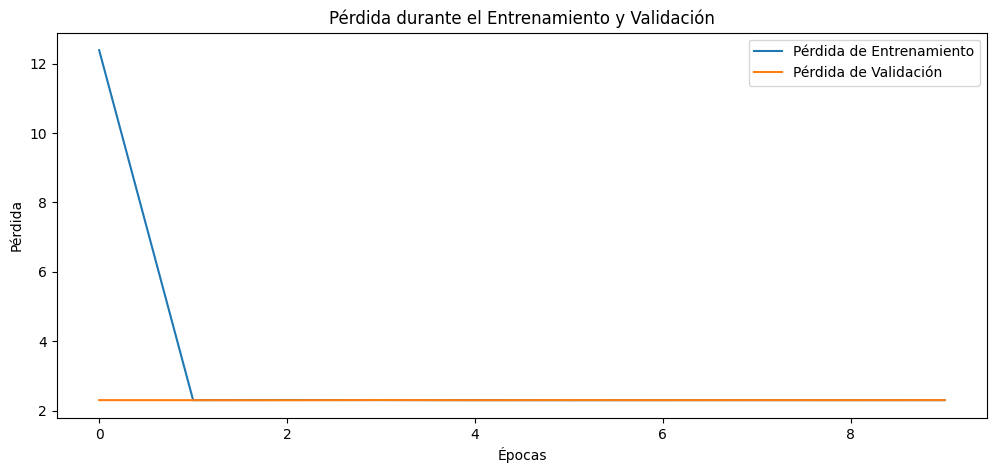

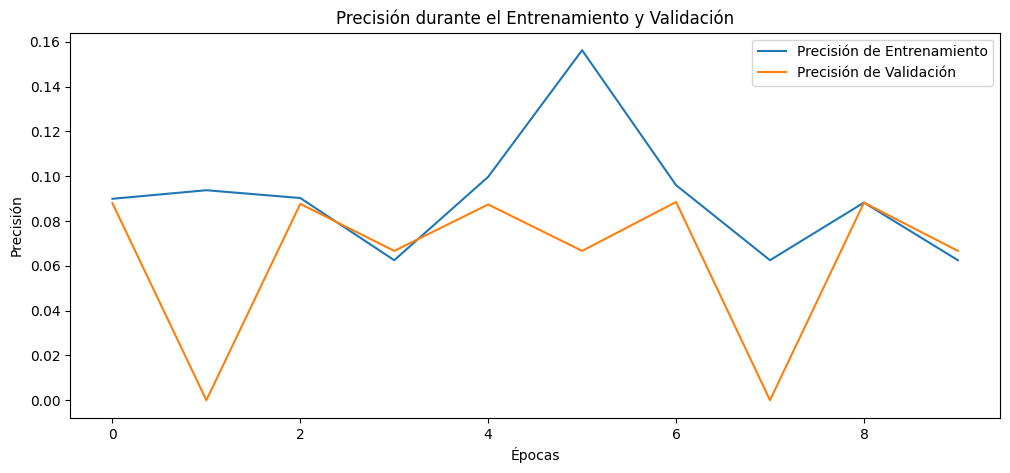

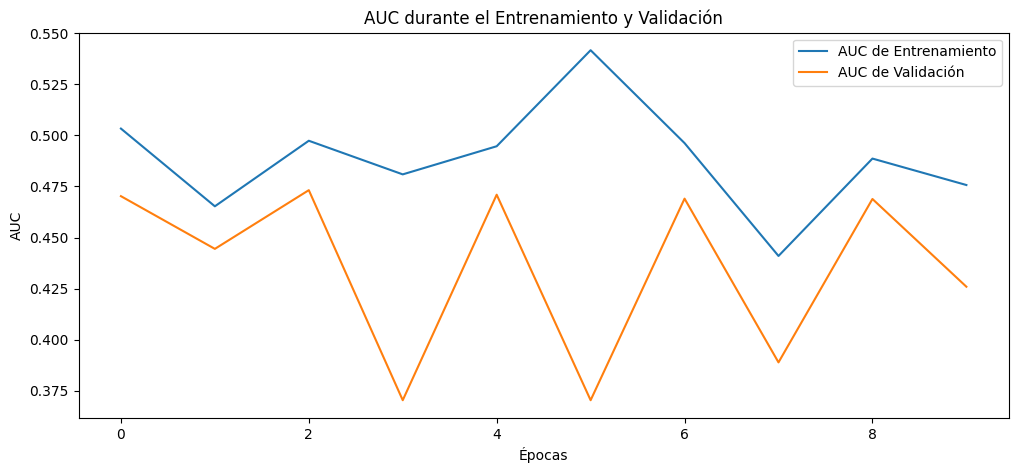

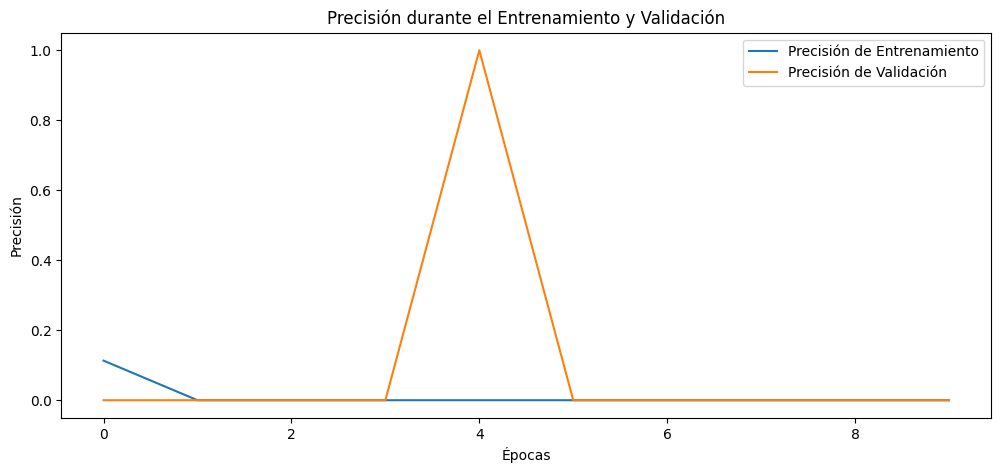

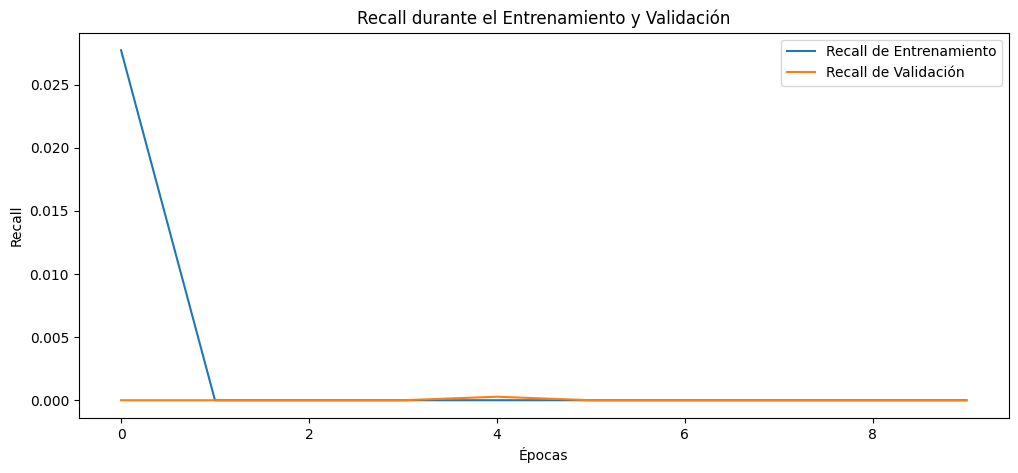

In [ ]:
# Entrenar el modelo y almacenar el historial de entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
)

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar las métricas adicionales (AUC, Precisión y Recall)
plt.figure(figsize=(12, 5))
plt.plot(history.history['auc'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc'], label='AUC de Validación')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.title('AUC durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.title('Recall durante el Entrenamiento y Validación')
plt.legend()
plt.show()

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 39s 351ms/step - accuracy: 0.3179 - auc: 0.7362 - loss: 2.0919 - precision: 0.4855 - recall: 0.1464 - val_accuracy: 0.1214 - val_auc: 0.6098 - val_loss: 2.5452 - val_precision: 0.1935 - val_recall: 0.0196
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7500 - auc: 0.9083 - loss: 1.1942 - precision: 1.0000 - recall: 0.5000 - val_accuracy: 0.0667 - val_auc: 0.5190 - val_loss: 2.9066 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 321ms/step - accuracy: 0.6302 - auc: 0.9277 - loss: 1.1434 - precision: 0.7963 - recall: 0.4092 - val_accuracy: 0.4466 - val_auc: 0.8226 - val_loss: 1.7063 - val_precision: 0.7614 - val_recall: 0.1615
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.7500 - auc: 0.9331 - loss: 1.0665 - precision: 0.8667 - recall: 0.4062 - val_accuracy: 0.2667 - val_auc: 0.8032 - val_loss: 1.7888 - val_precision: 0.5000 - val_recall: 0.0667
Epoch 5/50
93/93 ━━━━━━━

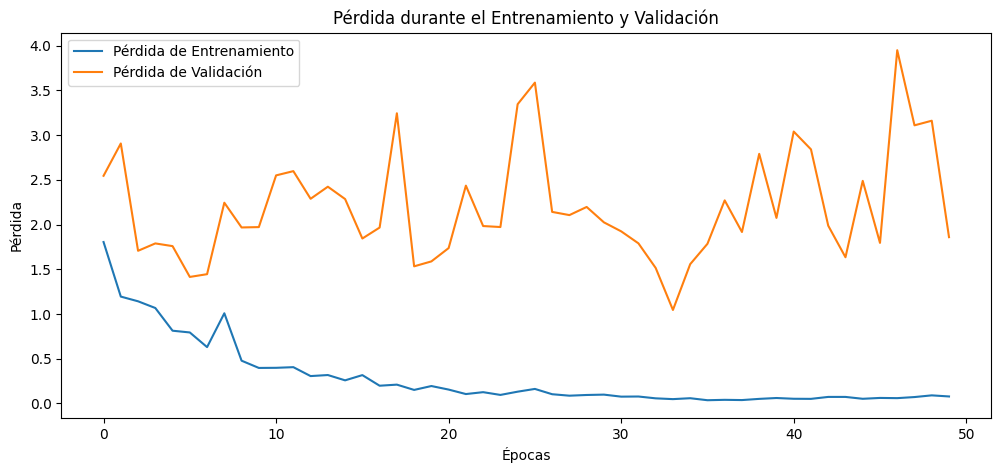

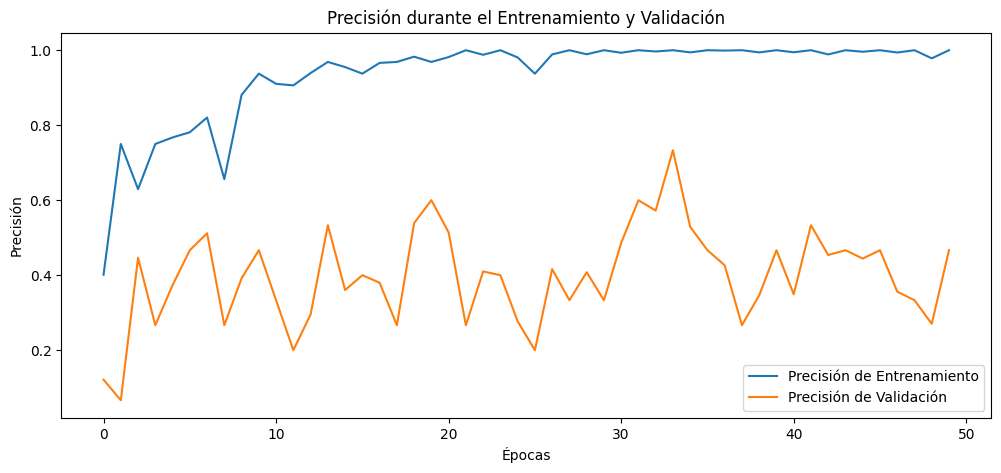

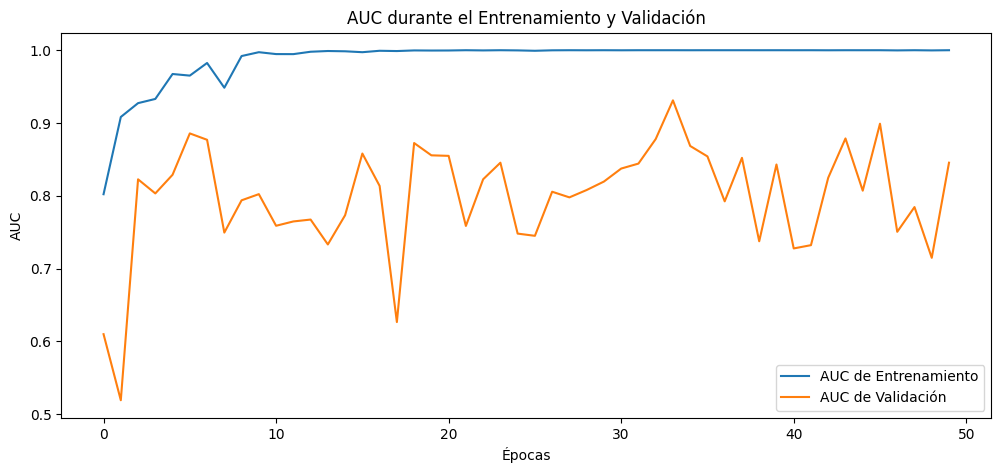

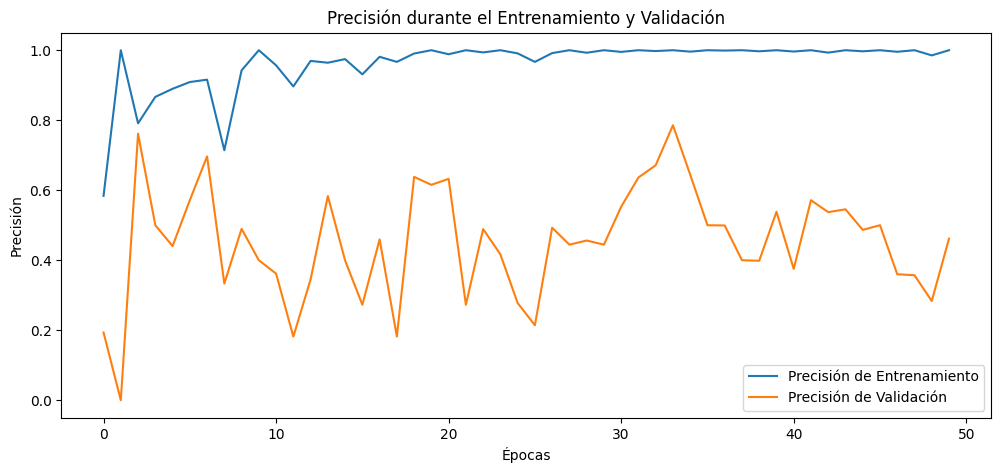

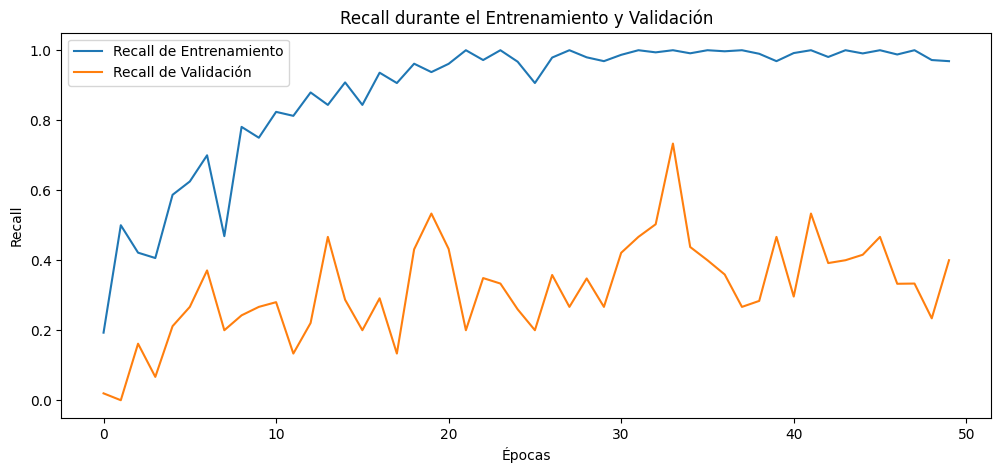

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Inicializar el modelo
model = Sequential()

# Aplanar la imagen 256x256x3 a un vector de 1D
model.add(Flatten(input_shape=(256, 256, 3)))

# Primera capa oculta con Batch Normalization
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

# Segunda capa oculta con Batch Normalization
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

# Tercera capa oculta con Batch Normalization
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# Cuarta capa oculta con Batch Normalization
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

# Capa de salida con una neurona por clase y softmax para clasificación
model.add(Dense(10, activation='softmax'))  # 10 clases en total

# Compilación del modelo con el learning rate reducido y métricas adicionales
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

# Entrenar el modelo y almacenar el historial de entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
)

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar las métricas adicionales (AUC, Precisión y Recall)
plt.figure(figsize=(12, 5))
plt.plot(history.history['auc'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc'], label='AUC de Validación')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.title('AUC durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.title('Recall durante el Entrenamiento y Validación')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 51s 428ms/step - accuracy: 0.1592 - auc: 0.5733 - loss: 4.4454 - precision: 0.1835 - recall: 0.0552 - val_accuracy: 0.1214 - val_auc: 0.6049 - val_loss: 4.3215 - val_precision: 0.1684 - val_recall: 0.0553
Epoch 2/50
 1/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.1562 - auc: 0.6538 - loss: 3.9969 - precision: 0.2727 - recall: 0.0938

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.1562 - auc: 0.6538 - loss: 3.9969 - precision: 0.2727 - recall: 0.0938 - val_accuracy: 0.2000 - val_auc: 0.7296 - val_loss: 3.7344 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - accuracy: 0.2543 - auc: 0.6922 - loss: 3.8421 - precision: 0.3690 - recall: 0.1213 - val_accuracy: 0.2882 - val_auc: 0.6768 - val_loss: 3.9794 - val_precision: 0.4003 - val_recall: 0.1587
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4688 - auc: 0.8024 - loss: 3.3279 - precision: 0.5833 - recall: 0.2188 - val_accuracy: 0.2667 - val_auc: 0.6447 - val_loss: 4.0582 - val_precision: 0.3333 - val_recall: 0.2000
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 331ms/step - accuracy: 0.3199 - auc: 0.7547 - loss: 3.5520 - precision: 0.4279 - recall: 0.1647 - val_accuracy: 0.4900 - val_auc: 0.8464 - val_loss: 3.0273 - val_precision: 0.8764 - val_recall: 0.2157
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━

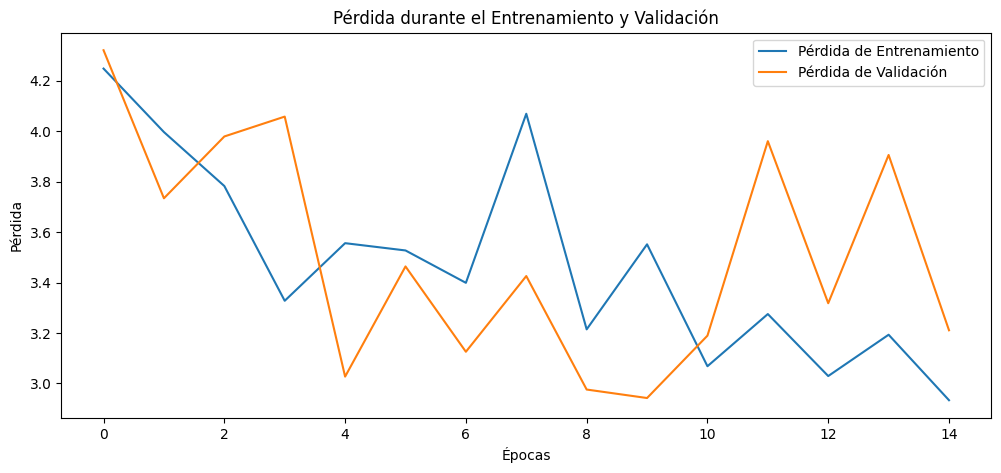

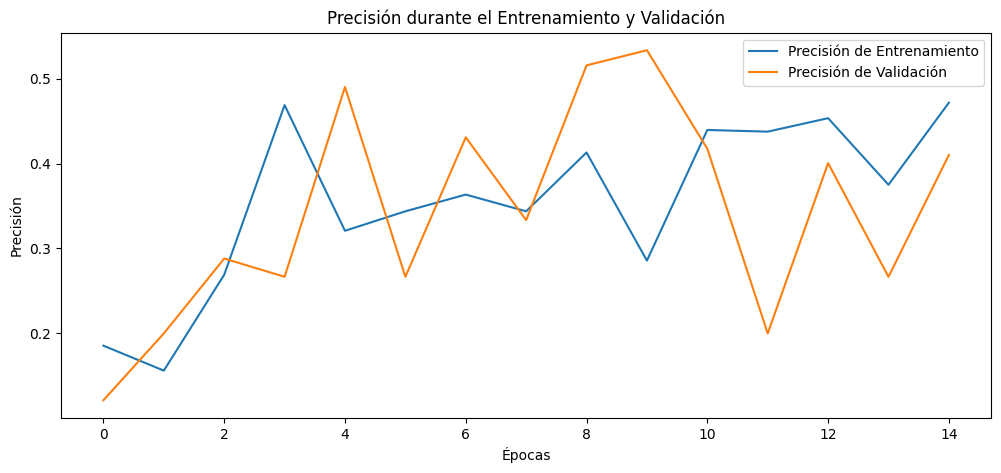

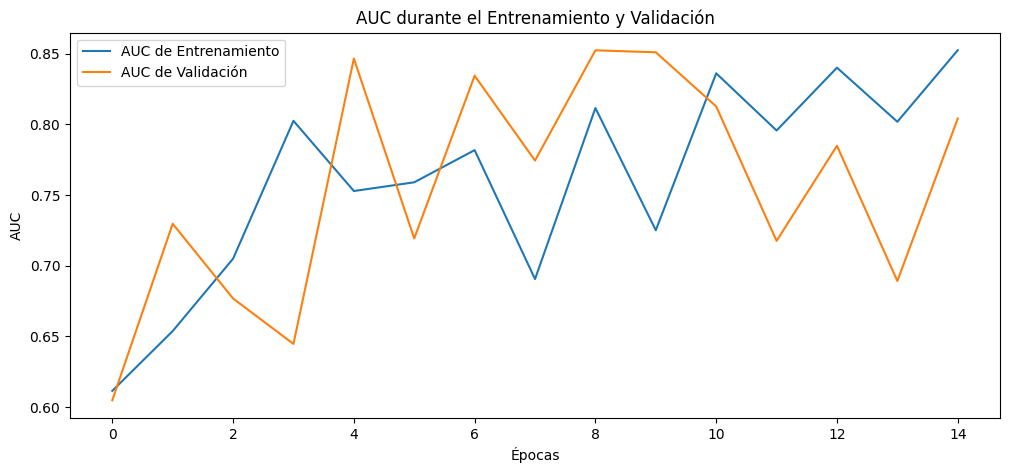

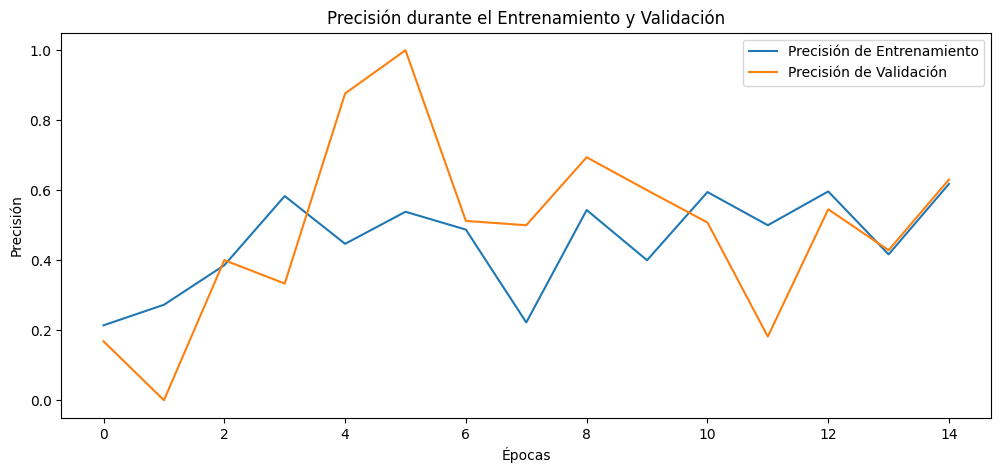

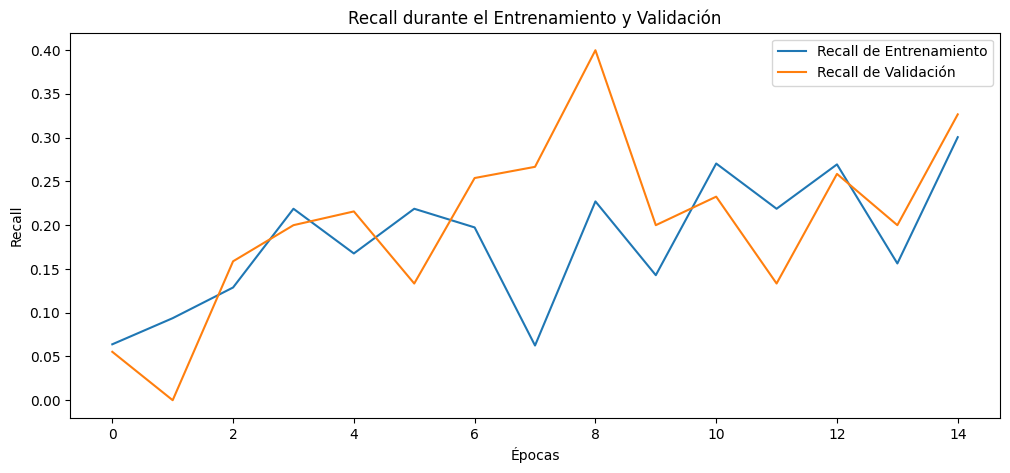

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Inicializar el modelo con Dropout y regularización L2
model = Sequential()
model.add(Flatten(input_shape=(256, 256, 3)))

# Primera capa oculta con regularización L2 y Dropout
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Segunda capa oculta con regularización L2 y Dropout
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Tercera capa oculta con regularización L2 y Dropout
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Cuarta capa oculta con regularización L2 y Dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida con una neurona por clase y softmax para clasificación
model.add(Dense(10, activation='softmax'))  # 10 clases en total

# Compilación del modelo con el learning rate reducido y métricas adicionales
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

# Callbacks: reducir el learning rate y detener el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo y almacenar el historial de entrenamiento
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar las métricas adicionales (AUC, Precisión y Recall)
plt.figure(figsize=(12, 5))
plt.plot(history.history['auc'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc'], label='AUC de Validación')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.title('AUC durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.title('Recall durante el Entrenamiento y Validación')
plt.legend()
plt.show()

114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.5060 - auc: 0.8489 - loss: 3.0019 - precision: 0.6745 - recall: 0.3952
Pérdida en el conjunto de prueba: 2.9807398319244385
Precisión en el conjunto de prueba: 0.5125309824943542
AUC en el conjunto de prueba: 0.8520036935806274
Precisión (Precision) en el conjunto de prueba: 0.6856600046157837
Recall en el conjunto de prueba: 0.39768660068511963
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step
Informe de Clasificación:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.10      0.07      0.08       425
                        Tomato___Early_blight       0.06      0.01      0.02       200
                         Tomato___Late_blight       0.11      0.13      0.12       382
                           Tomato___Leaf_Mold       0.02      0.01      0.01       191
                  Tomato___Septoria_leaf_spot       0.09      0.01      0.02       354
T

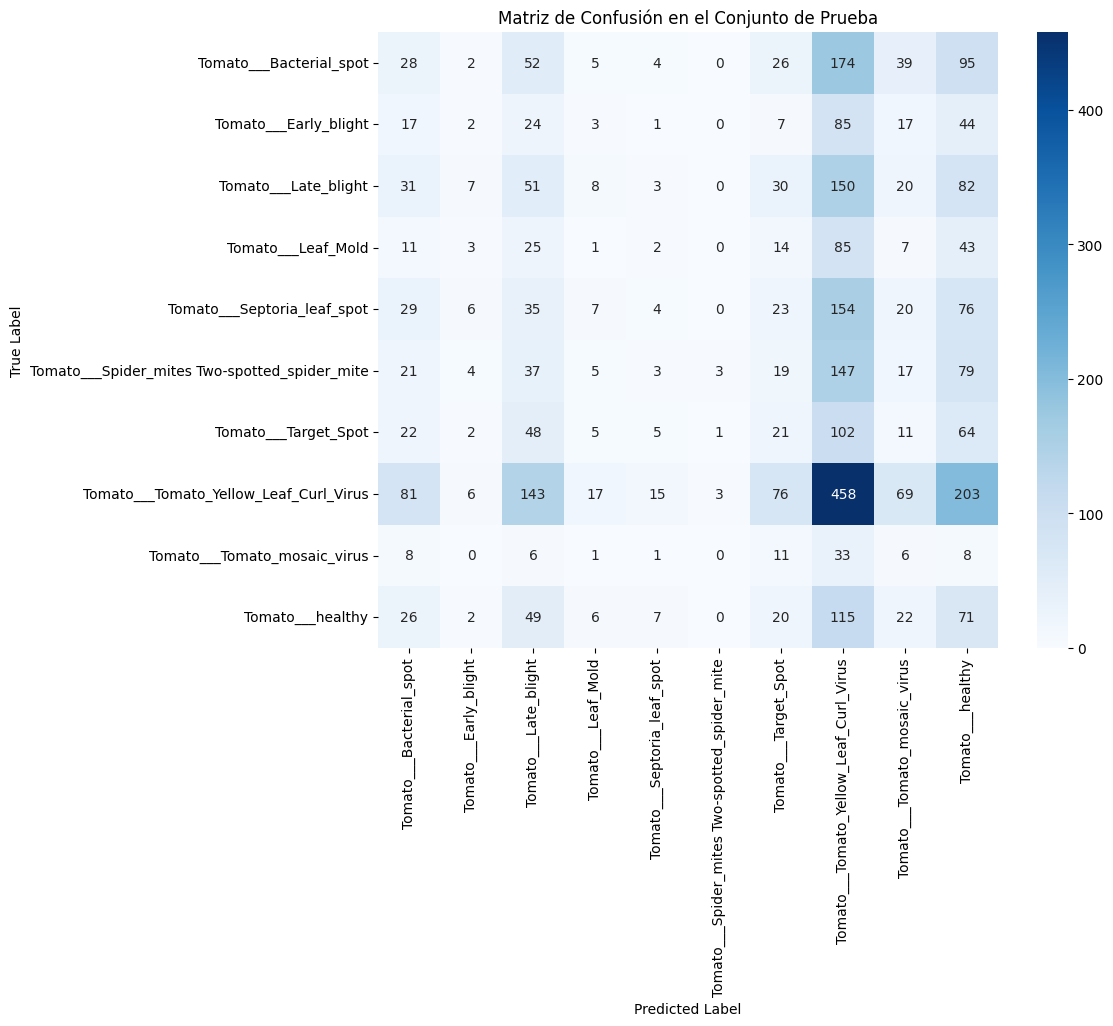

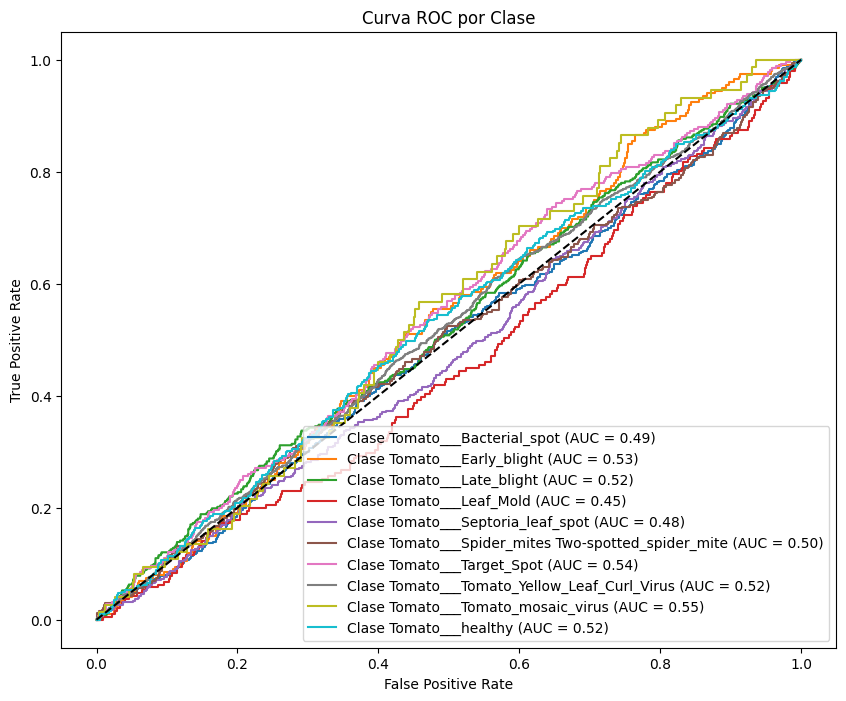

In [ ]:
# Evaluar el modelo en el conjunto de prueba (val_generator)
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(val_generator)

# Imprimir los resultados de la evaluación
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")
print(f"AUC en el conjunto de prueba: {test_auc}")
print(f"Precisión (Precision) en el conjunto de prueba: {test_precision}")
print(f"Recall en el conjunto de prueba: {test_recall}")

# Obtener predicciones para graficar y para el informe de clasificación
predictions = model.predict(val_generator)
predicted_classes = predictions.argmax(axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generar e imprimir el informe de clasificación
from sklearn.metrics import classification_report

classification_report_str = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Informe de Clasificación:")
print(classification_report_str)

# Graficar la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión en el Conjunto de Prueba")
plt.show()

# Graficar curva ROC y calcular AUC por clase (si es multiclase)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convertir etiquetas verdaderas a formato binarizado
true_classes_bin = label_binarize(true_classes, classes=np.arange(10))

# Graficar ROC por cada clase
plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Clase {class_labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC por Clase")
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 46s 392ms/step - accuracy: 0.1088 - auc: 0.5209 - loss: 6.3684 - precision: 0.1278 - recall: 0.0429 - val_accuracy: 0.0581 - val_auc: 0.5694 - val_loss: 7.2509 - val_precision: 0.0558 - val_recall: 0.0548 - learning_rate: 1.0000e-04
Epoch 2/50
 1/93 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2188 - auc: 0.6270 - loss: 5.6096 - precision: 0.2500 - recall: 0.0938

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2188 - auc: 0.6270 - loss: 5.6096 - precision: 0.2500 - recall: 0.0938 - val_accuracy: 0.0667 - val_auc: 0.5321 - val_loss: 7.5956 - val_precision: 0.0714 - val_recall: 0.0667 - learning_rate: 1.0000e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 324ms/step - accuracy: 0.1696 - auc: 0.6204 - loss: 5.6800 - precision: 0.1914 - recall: 0.0630 - val_accuracy: 0.1728 - val_auc: 0.6032 - val_loss: 5.8438 - val_precision: 0.2568 - val_recall: 0.0810 - learning_rate: 1.0000e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1562 - auc: 0.6809 - loss: 5.4426 - precision: 0.1000 - recall: 0.0312 - val_accuracy: 0.2667 - val_auc: 0.5953 - val_loss: 5.7444 - val_precision: 0.2500 - val_recall: 0.0667 - learning_rate: 1.0000e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 332ms/step - accuracy: 0.2055 - auc: 0.6600 - loss: 5.4343 - precision: 0.2449 - recall: 0.0876 - val_accuracy: 0.2636 - val_auc: 0.7097 - val_loss: 4.9872 - val

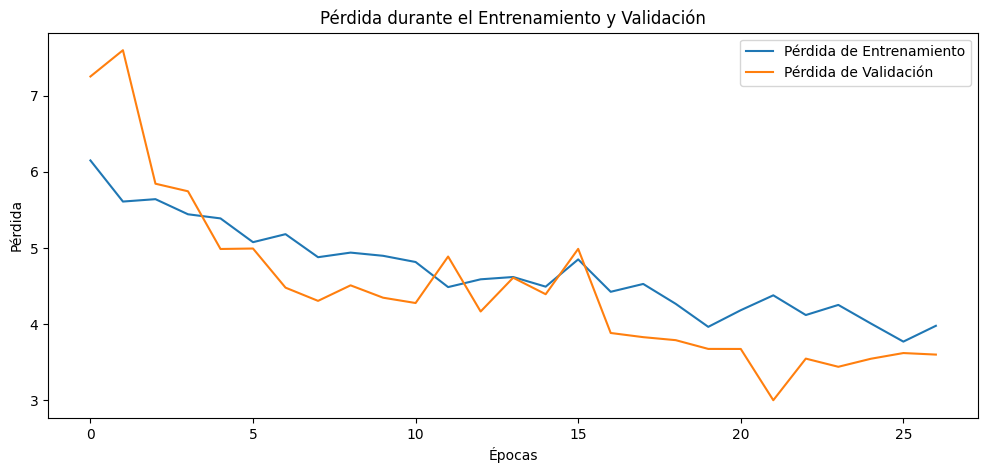

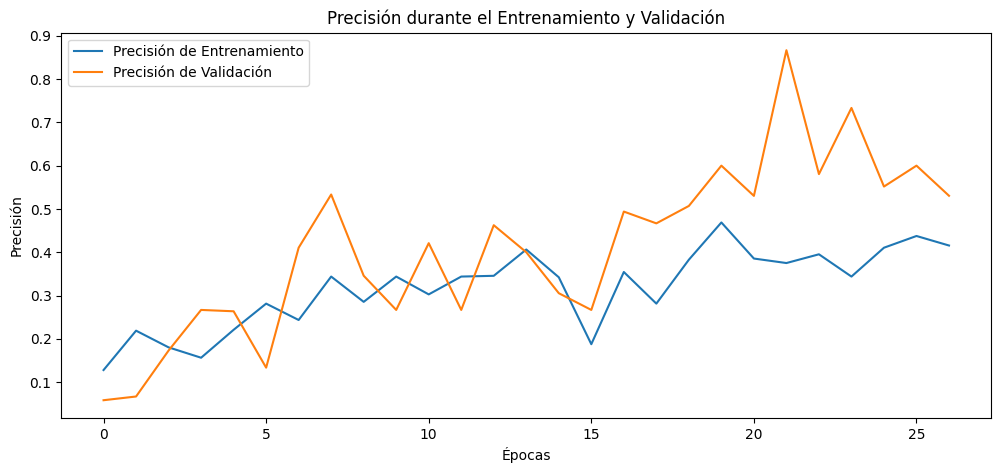

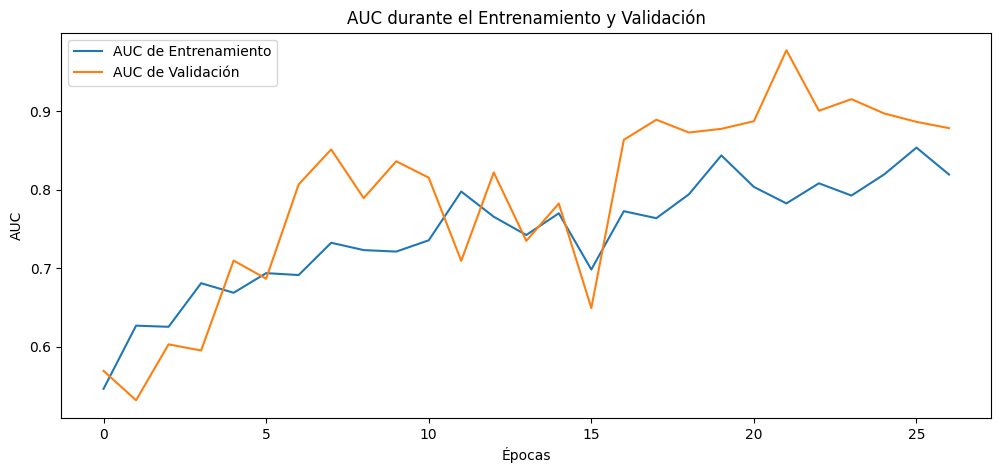

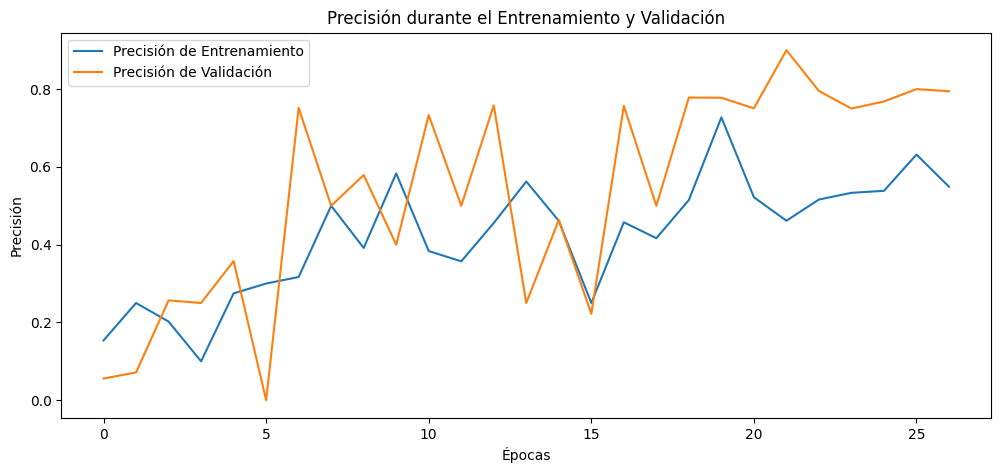

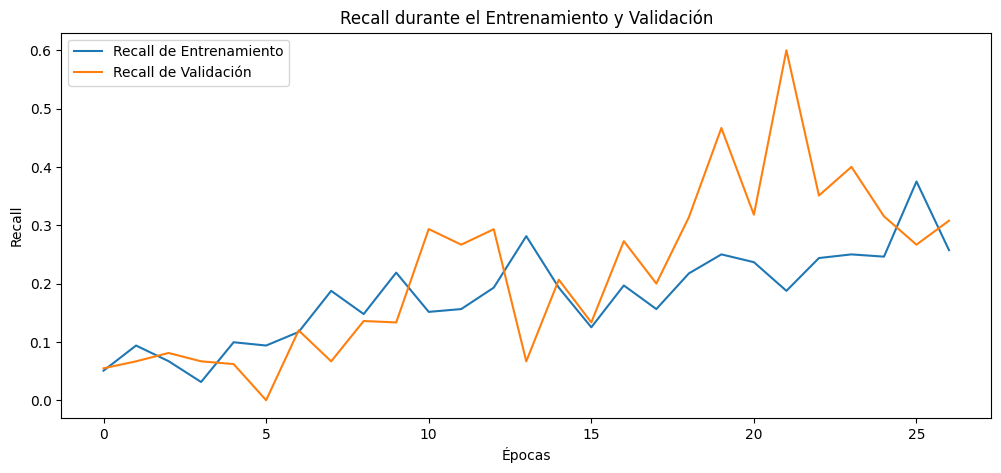

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Calcular los pesos de cada clase para el balanceo
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

# Inicializar el modelo con Dropout y regularización L2 adicional
model = Sequential()
model.add(Flatten(input_shape=(256, 256, 3)))

# Primera capa oculta con regularización L2 y Dropout
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Segunda capa oculta con regularización L2 y Dropout
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Tercera capa oculta con regularización L2 y Dropout
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Cuarta capa oculta con regularización L2 y Dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Capa de salida con una neurona por clase y softmax para clasificación
model.add(Dense(10, activation='softmax'))  # 10 clases en total

# Compilación del modelo con el learning rate reducido y métricas adicionales
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

# Callbacks: reducir el learning rate y detener el entrenamiento temprano
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo usando class_weight para el balanceo de clases
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
)

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar la precisión
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

# Graficar las métricas adicionales (AUC, Precisión y Recall)
plt.figure(figsize=(12, 5))
plt.plot(history.history['auc'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc'], label='AUC de Validación')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.title('AUC durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['precision'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento y Validación')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['recall'], label='Recall de Entrenamiento')
plt.plot(history.history['val_recall'], label='Recall de Validación')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.title('Recall durante el Entrenamiento y Validación')
plt.legend()
plt.show()

114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.5335 - auc: 0.8873 - loss: 3.6708 - precision: 0.7554 - recall: 0.3207
Pérdida en el conjunto de prueba: 3.6770005226135254
Precisión en el conjunto de prueba: 0.5312585830688477
AUC en el conjunto de prueba: 0.8862945437431335
Precisión (Precision) en el conjunto de prueba: 0.7517776489257812
Recall en el conjunto de prueba: 0.3202974498271942
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step
Informe de Clasificación:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.11      0.25      0.15       425
                        Tomato___Early_blight       0.07      0.10      0.09       200
                         Tomato___Late_blight       0.12      0.16      0.14       382
                           Tomato___Leaf_Mold       0.06      0.05      0.05       191
                  Tomato___Septoria_leaf_spot       0.08      0.01      0.02       354
To

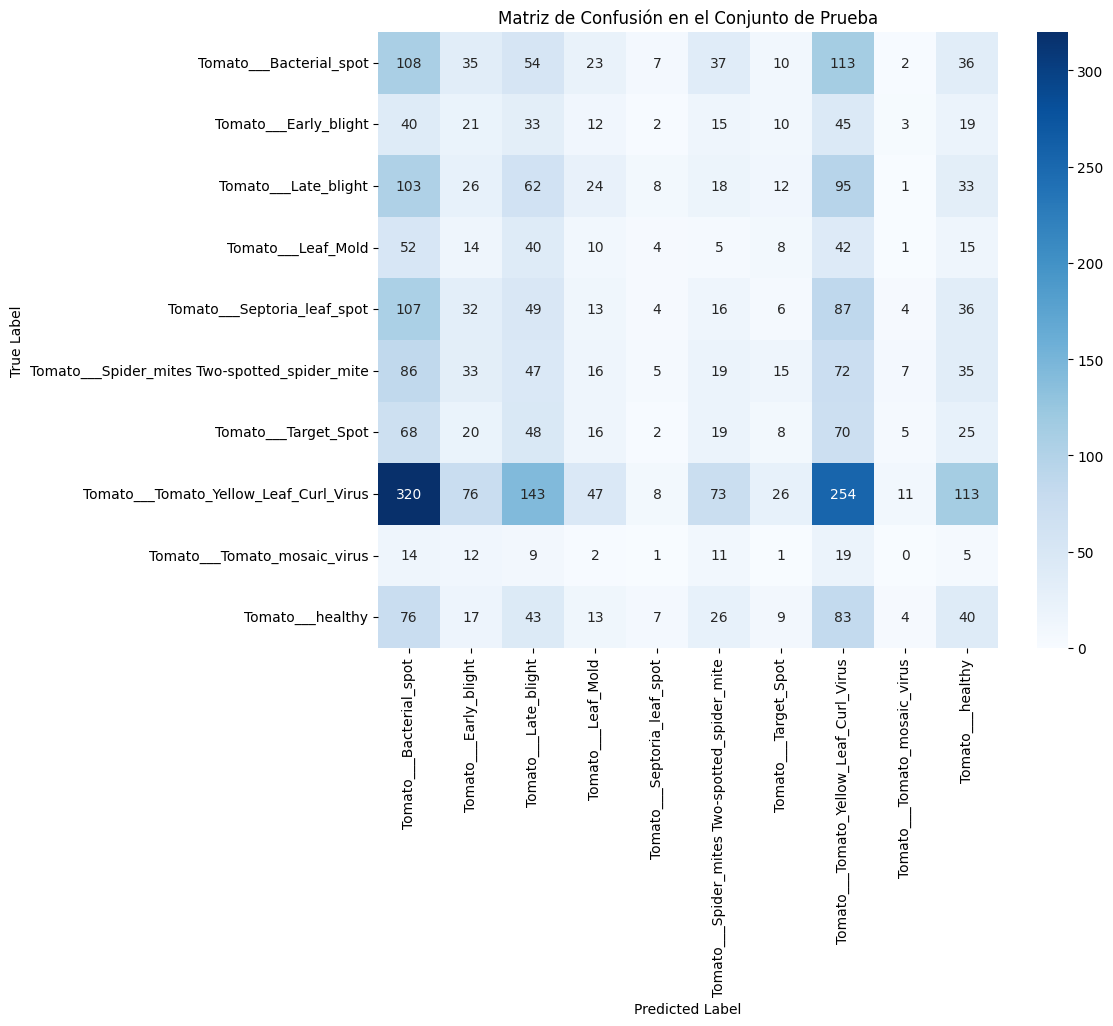

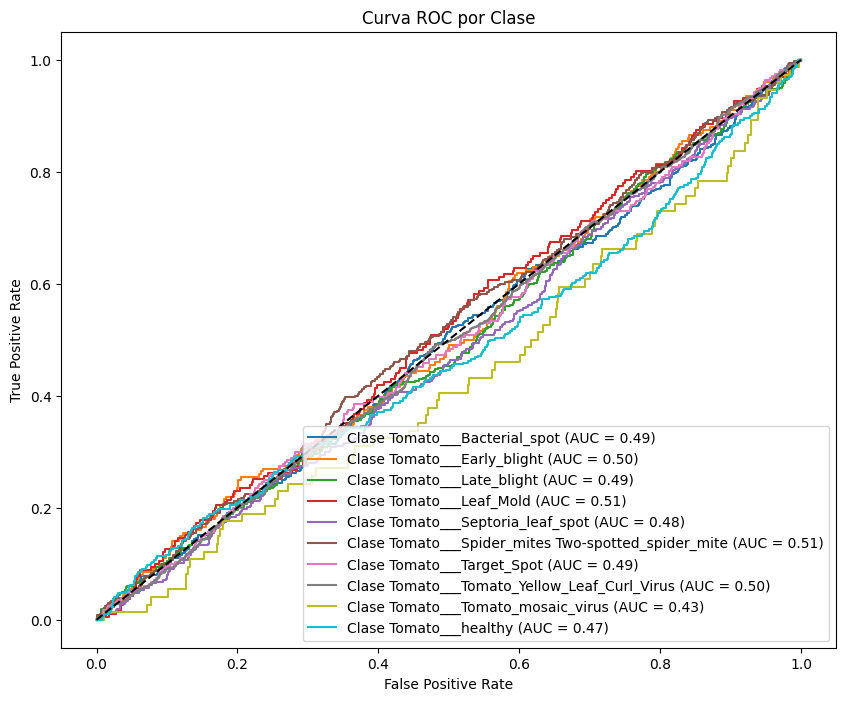

In [ ]:
# Evaluar el modelo en el conjunto de prueba (val_generator)
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(val_generator)

# Imprimir los resultados de la evaluación
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")
print(f"AUC en el conjunto de prueba: {test_auc}")
print(f"Precisión (Precision) en el conjunto de prueba: {test_precision}")
print(f"Recall en el conjunto de prueba: {test_recall}")

# Obtener predicciones para graficar y para el informe de clasificación
predictions = model.predict(val_generator)
predicted_classes = predictions.argmax(axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generar e imprimir el informe de clasificación
from sklearn.metrics import classification_report

classification_report_str = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Informe de Clasificación:")
print(classification_report_str)

# Graficar la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión en el Conjunto de Prueba")
plt.show()

# Graficar curva ROC y calcular AUC por clase (si es multiclase)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convertir etiquetas verdaderas a formato binarizado
true_classes_bin = label_binarize(true_classes, classes=np.arange(10))

# Graficar ROC por cada clase
plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Clase {class_labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC por Clase")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Define the model with the layers list
model = Sequential([
    # Flatten layer
    Flatten(input_shape=(256, 256, 3)),

    # First dense layer with L2 regularization, BatchNormalization, and Dropout
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    # Second dense layer with L2 regularization, BatchNormalization, and Dropout
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    # Third dense layer with L2 regularization, BatchNormalization, and Dropout
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    # Fourth dense layer with L2 regularization, BatchNormalization, and Dropout
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer with softmax activation
    Dense(len(class_names), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)                  │ (None, 196608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 512)                 │     100,663,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,840,778 (384.68 MB)

 Trainable params: 100,838,858 (384.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Custom callback for precision, recall, and F1-score
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Initialize variables for tracking true and predicted labels
        y_true, y_pred = [], []

        # Iterate over the validation dataset
        for x_batch, y_batch in val_dataset:
            predictions = model.predict(x_batch, verbose=0)
            y_true.extend(y_batch.numpy())
            y_pred.extend(np.argmax(predictions, axis=1))

        # Calculate metrics
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Log the metrics
        logs['val_precision'] = precision
        logs['val_recall'] = recall
        logs['val_f1'] = f1

        # Print metrics for this epoch
        print(f" - val_precision: {precision:.4f} - val_recall: {recall:.4f} - val_f1: {f1:.4f}")

# Prepare datasets
BATCH_SIZE = 32
EPOCHS = 20

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Train the model with early stopping and metrics callback
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, MetricsCallback()]
)

Epoch 1/20
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3603 - loss: 5.5431 - val_precision: 0.4960 - val_recall: 0.4269 - val_f1: 0.3661
455/455 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - accuracy: 0.3605 - loss: 5.5416 - val_accuracy: 0.4269 - val_loss: 3.8707 - val_precision: 0.4960 - val_recall: 0.4269 - val_f1: 0.3661
Epoch 2/20
  3/455 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.6111 - loss: 3.5574

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5621 - loss: 3.3834 - val_precision: 0.3269 - val_recall: 0.4354 - val_f1: 0.3276
455/455 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.5622 - loss: 3.3825 - val_accuracy: 0.4354 - val_loss: 3.6613 - val_precision: 0.3269 - val_recall: 0.4354 - val_f1: 0.3276
Epoch 3/20
  3/455 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5990 - loss: 2.7891

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5920 - loss: 2.7859 - val_precision: 0.4841 - val_recall: 0.1234 - val_f1: 0.0466
455/455 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.5920 - loss: 2.7859 - val_accuracy: 0.1234 - val_loss: 5.5667 - val_precision: 0.4841 - val_recall: 0.1234 - val_f1: 0.0466
Epoch 4/20
  3/455 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6181 - loss: 2.6660

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5968 - loss: 2.9286 - val_precision: 0.4150 - val_recall: 0.3966 - val_f1: 0.3254
455/455 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5968 - loss: 2.9289 - val_accuracy: 0.3966 - val_loss: 3.6036 - val_precision: 0.4150 - val_recall: 0.3966 - val_f1: 0.3254
Epoch 5/20
  3/455 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.6354 - loss: 2.8280

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6126 - loss: 3.0030 - val_precision: 0.2872 - val_recall: 0.2388 - val_f1: 0.2301
455/455 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.6126 - loss: 3.0034 - val_accuracy: 0.2388 - val_loss: 4.9911 - val_precision: 0.2872 - val_recall: 0.2388 - val_f1: 0.2301
Epoch 6/20
  3/455 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.6250 - loss: 2.9364

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6125 - loss: 2.7896 - val_precision: 0.3236 - val_recall: 0.3718 - val_f1: 0.2667
455/455 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.6124 - loss: 2.7894 - val_accuracy: 0.3718 - val_loss: 4.2522 - val_precision: 0.3236 - val_recall: 0.3718 - val_f1: 0.2667
Epoch 7/20
  2/455 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.7109 - loss: 2.5915 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


453/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6209 - loss: 2.6132 - val_precision: 0.2316 - val_recall: 0.3616 - val_f1: 0.2654
455/455 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.6208 - loss: 2.6130 - val_accuracy: 0.3616 - val_loss: 4.7809 - val_precision: 0.2316 - val_recall: 0.3616 - val_f1: 0.2654


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluate the model and calculate additional metrics
def evaluate_metrics(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate ROC-AUC (for binary classification or one-vs-rest approach)
    if len(class_names) == 2:  # Binary classification
        y_proba = model.predict(dataset.map(lambda x, y: x))
        roc_auc = roc_auc_score(y_true, y_proba[:, 1])  # Probability of positive class
        print(f"ROC-AUC: {roc_auc}")

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    return precision, recall, f1

# Evaluate metrics on the validation dataset
evaluate_metrics(model, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.4149871703780729, 0.39658496282015976, 0.32536654317868763)

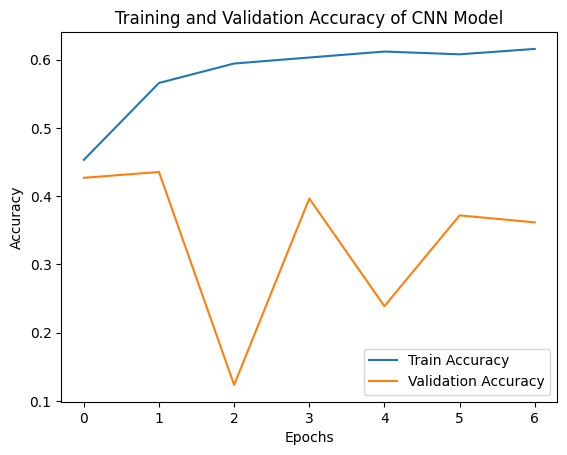

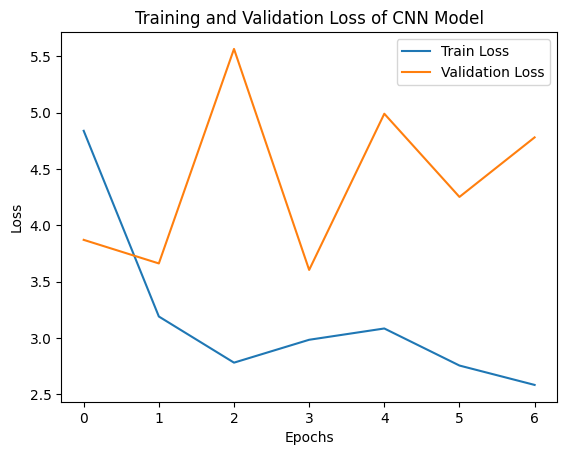

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy of CNN Model')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of CNN Model')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

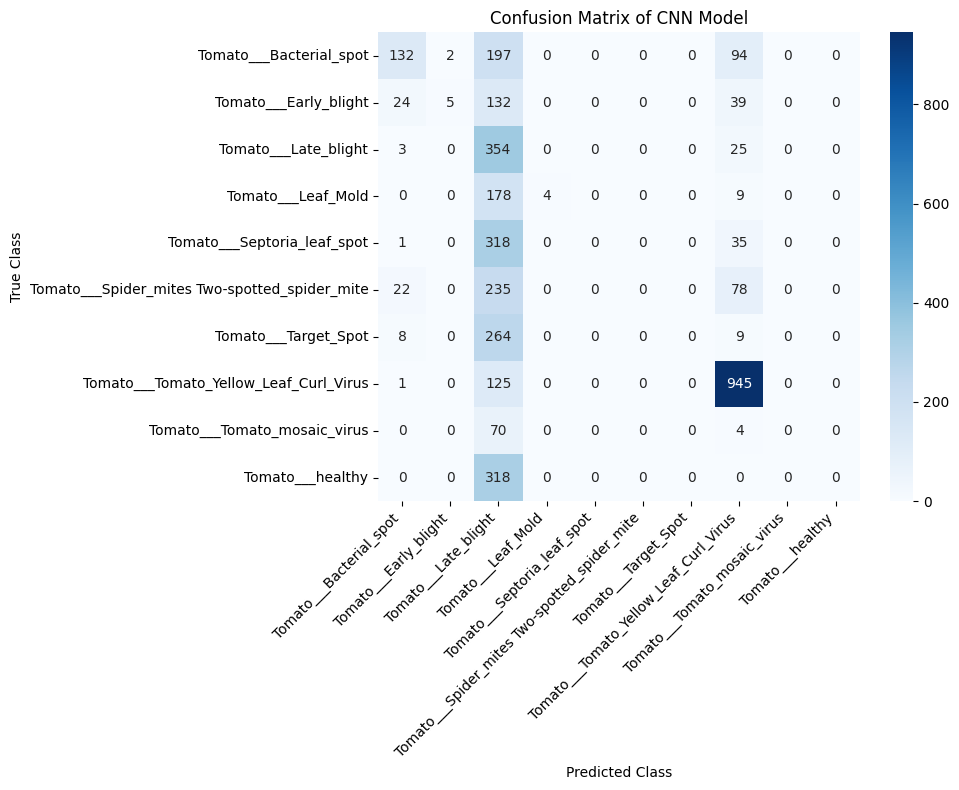

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate over validation dataset
for images, labels in val_dataset:
    # Get model predictions for the batch
    predictions = model.predict(images)

    # Extend the true labels and predicted labels lists
    y_true.extend(labels.numpy())  # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels (get the class with highest probability)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix of CNN Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Generate and print the classification report of CNN Model
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report of CNN Model:")
print(class_report)

Classification Report of CNN Model:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.69      0.31      0.43       425
                        Tomato___Early_blight       0.71      0.03      0.05       200
                         Tomato___Late_blight       0.16      0.93      0.28       382
                           Tomato___Leaf_Mold       1.00      0.02      0.04       191
                  Tomato___Septoria_leaf_spot       0.00      0.00      0.00       354
Tomato___Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00       335
                         Tomato___Target_Spot       0.00      0.00      0.00       281
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.76      0.88      0.82      1071
                 Tomato___Tomato_mosaic_virus       0.00      0.00      0.00        74
                             Tomato___healthy       0.00      0.00      0.00       318

     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
